# Backtest Evaluation – Holding + Trend Filter + Volatility Filter (v1)

Adds a volatility regime filter on top of the trend-filtered holding strategy:
- Trend: ret_20d > 0
- Volatility: rvol_10 <= percentile threshold (computed on test set)

Input: data/curated/features_daily.parquet


In [ ]:
# Core libraries for data manipulation, numerics and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


In [ ]:
# Load feature table produced by the pipeline and ensure deterministic ordering
# Expected columns include multi-day returns and realized next-day return y_ret_1d
df = pd.read_parquet("../data/curated/features_daily.parquet")
df = df.sort_values(["symbol", "date"]).reset_index(drop=True)
print(df.shape)
df.head()


(8199, 14)


,date,adj close,close,high,low,open,volume,symbol,ret_1d,ret_5d,ret_10d,ret_20d,rvol_10,y_ret_1d
0,2015-02-02,26.299284,29.657499,29.792500,29.020000,29.512501,250956400,AAPL,0.012469,0.047737,0.112665,0.081639,0.400539,0.000169
1,2015-02-03,26.303715,29.662500,29.772499,29.402500,29.625000,207662800,AAPL,0.000169,0.083547,0.087402,0.110383,0.395570,0.007640
2,2015-02-04,26.505453,29.889999,30.127501,29.577499,29.625000,280598800,AAPL,0.007640,0.036194,0.087437,0.117929,0.395567,0.003173
3,2015-02-05,26.694641,29.985001,30.057501,29.812500,30.004999,168984800,AAPL,0.003173,0.008709,0.064928,0.107178,0.384564,-0.008457
4,2015-02-06,26.469841,29.732500,30.062500,29.612499,30.004999,174826400,AAPL,-0.008457,0.014995,0.051324,0.061019,0.391890,0.006621


In [ ]:
# Feature/target setup and a time-based train/test split (no shuffling to avoid leakage)
FEATURES = ["ret_1d", "ret_5d", "ret_10d", "ret_20d", "rvol_10"]
TARGET = "y_ret_1d"

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:].copy()

# Train a simple linear baseline and predict on test partition
model = LinearRegression()
model.fit(train[FEATURES], train[TARGET])

test["prediction"] = model.predict(test[FEATURES])


In [ ]:
# Strategy hyperparameters and volatility thresholding
HOLD_DAYS = 5
COST_BPS = 5
COST = COST_BPS / 10_000

# Prediction threshold derived from variability of model outputs
pred_std = test["prediction"].std()
THRESHOLD = 0.5 * pred_std

# Volatility filter: allow trading only when rvol_10 is below the chosen percentile
VOL_PCTL = 0.60
VOL_THRESHOLD = float(test["rvol_10"].quantile(VOL_PCTL))

print("Holding days:", HOLD_DAYS)
print("Prediction threshold:", THRESHOLD)
print("Vol threshold:", VOL_THRESHOLD, f"(pctl={VOL_PCTL})")


Holding days: 5
Prediction threshold: 0.0005809406808180979
Vol threshold: 0.15434497305307493 (pctl=0.6)


In [ ]:
# Per-symbol loop: enforce trend filter, volatility filter, thresholding and holding period
records = []

for symbol, sdf in test.groupby("symbol"):
    sdf = sdf.copy().reset_index(drop=True)

    position = 0.0
    days_left = 0

    for i in range(len(sdf)):
        row = sdf.loc[i]
        trade_cost = 0.0

        # Require both trend and volatility conditions to be satisfied
        trend_ok = row["ret_20d"] > 0
        vol_ok = row["rvol_10"] <= VOL_THRESHOLD

        # Countdown for minimum holding period
        if days_left > 0:
            days_left -= 1

        # Open position only if flat, trend and vol filters pass, and prediction strong
        if position == 0.0 and trend_ok and vol_ok and row["prediction"] > THRESHOLD:
            position = min(row["prediction"] / pred_std, 1.0)
            days_left = HOLD_DAYS
            trade_cost = position * COST
        # Close position when minimum hold expires
        elif position > 0.0 and days_left == 0:
            trade_cost = position * COST
            position = 0.0

        # Compute gross and net returns for this symbol/date
        gross_ret = position * row["y_ret_1d"]
        net_ret = gross_ret - trade_cost

        records.append({
            "date": row["date"], "symbol": symbol, "position": position, "net_ret": net_ret,
            "trend_ok": trend_ok, "vol_ok": vol_ok
        })

# Assemble backtest dataframe for aggregation and plotting
bt = pd.DataFrame(records)
bt.head()


,date,symbol,position,net_ret,trend_ok,vol_ok
0,2019-06-06,SPY,0.000000,0.000000,False,False
1,2019-06-07,SPY,0.000000,0.000000,True,False
2,2019-06-10,SPY,0.000000,-0.000000,True,False
3,2019-06-11,SPY,0.000000,-0.000000,True,True
4,2019-06-12,SPY,0.565601,0.002046,True,True


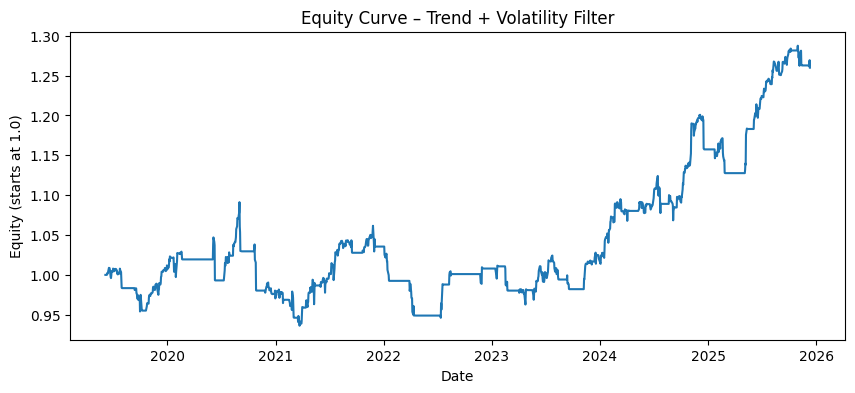

In [ ]:
# Aggregate daily portfolio returns by averaging across symbols and build equity curve
daily = bt.groupby("date", as_index=False)["net_ret"].mean().rename(columns={"net_ret": "portfolio_ret"})
daily["cum_log_ret"] = daily["portfolio_ret"].cumsum()
daily["equity"] = np.exp(daily["cum_log_ret"])

plt.figure(figsize=(10, 4))
plt.plot(daily["date"], daily["equity"])
plt.title("Equity Curve – Trend + Volatility Filter")
plt.xlabel("Date")
plt.ylabel("Equity (starts at 1.0)")
plt.show()


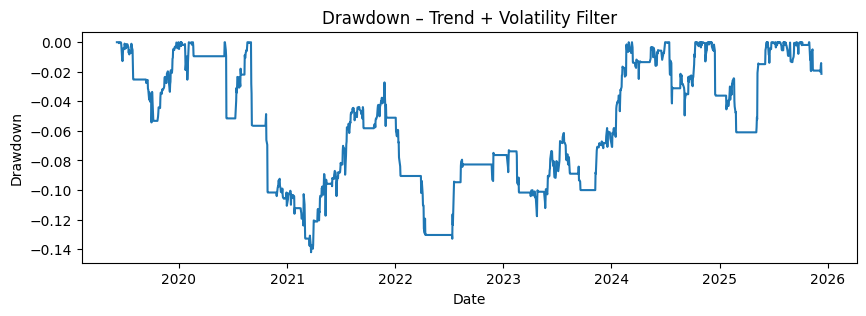

In [ ]:
# Compute drawdown relative to the running peak of equity
daily["rolling_max"] = daily["equity"].cummax()
daily["drawdown"] = daily["equity"] / daily["rolling_max"] - 1

plt.figure(figsize=(10, 3))
plt.plot(daily["date"], daily["drawdown"])
plt.title("Drawdown – Trend + Volatility Filter")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.show()


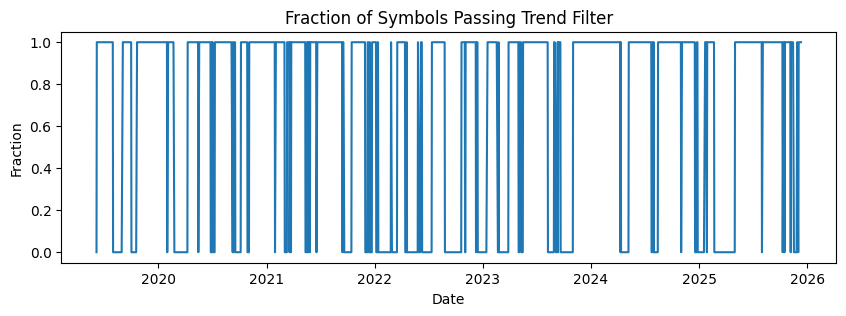

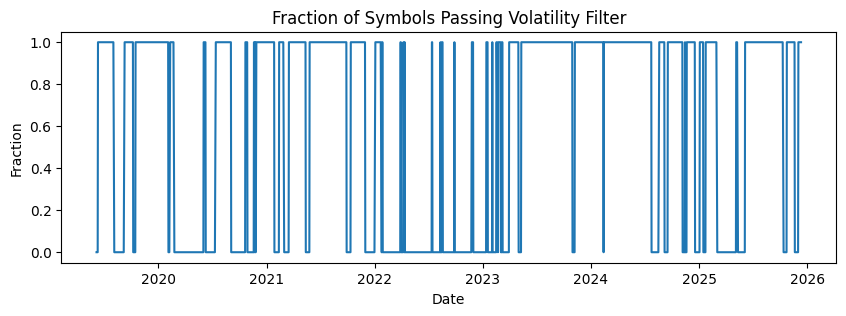

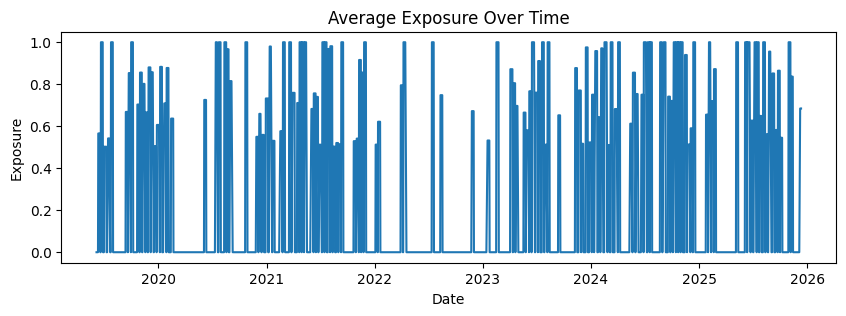

In [ ]:
# Compute activity metrics: fraction passing filters, invested fraction, and avg position
activity = bt.groupby("date", as_index=False).agg(
    trend_ok_frac=("trend_ok", "mean"),
    vol_ok_frac=("vol_ok", "mean"),
    invested=("position", lambda s: (s > 0).mean()),
    avg_position=("position", "mean"),
)

# Plot fractions and exposure over time to understand regime behavior
plt.figure(figsize=(10, 3))
plt.plot(activity["date"], activity["trend_ok_frac"])
plt.title("Fraction of Symbols Passing Trend Filter")
plt.xlabel("Date")
plt.ylabel("Fraction")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(activity["date"], activity["vol_ok_frac"])
plt.title("Fraction of Symbols Passing Volatility Filter")
plt.xlabel("Date")
plt.ylabel("Fraction")
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(activity["date"], activity["avg_position"])
plt.title("Average Exposure Over Time")
plt.xlabel("Date")
plt.ylabel("Exposure")
plt.show()


In [ ]:
# Compute summary performance metrics: total return, avg daily return, volatility, Sharpe, hit rate
total_return = daily["equity"].iloc[-1] - 1
avg_daily = daily["portfolio_ret"].mean()
vol_daily = daily["portfolio_ret"].std()
sharpe = (avg_daily / vol_daily) * np.sqrt(252) if vol_daily > 0 else np.nan
hit_rate = (daily["portfolio_ret"] > 0).mean()

print(f"Total return:     {total_return:.2%}")
print(f"Avg daily return: {avg_daily:.6e}")
print(f"Daily vol:        {vol_daily:.6e}")
print(f"Sharpe (approx):  {sharpe:.3f}")
print(f"Hit rate:         {hit_rate:.2%}")


Total return:     26.00%
Avg daily return: 1.409231e-04
Daily vol:        4.490979e-03
Sharpe (approx):  0.498
Hit rate:         22.68%
